# Files needed

* `Plenum/style.mplstyle`
* `Plenum/resources/point-source_discovery_time-evolution.csv`
* `Plenum/resources/ngc_paper_68_contour.txt`
* `Plenum/resources/ngc_contour_spl.csv`
* `Plenum/resources/ngc_2D_LLH_scan_exp.csv` (new)
* `Plenum/resources/ngc_paper_68_contour.txt` (new)
* `Plenum/resources/tenyr_paper_68_contour.txt` (new)
* `Plenum/resources/local_background_ngc.txt`
* `Plenum/resources/background_events_baseline.txt`
* `Plenum/resources/background_events_improved.txt`
* `Plenum/resources/PL_events_baseline.txt`
* `Plenum/resources/PL_events_improved.txt`
* `Plenum/resources/PLC_events_baseline.txt`
* `Plenum/resources/PLC_events_improved.txt`


# Import & settings

In [1]:
from os.path import join
from collections import namedtuple
import warnings
import numpy as np
import pandas as pd
from scipy.stats import chi2

# PLEnuM settings.py
import settings as st

# plot settings
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.style.use("/home/hpc/capn/capn102h/repos/Plenum/style.mplstyle")

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


In [2]:
def get_mids(bins, ext=False):
    """Calculate the bin mids from an array of bin edges."""
    res = (bins[1:] + bins[:-1]) * 0.5
    if ext == False:
        return res
    else:
        res[0], res[-1] = bins[0], bins[-1]
        return res
def power_law(energy, e_scale, gamma, phi0):
    return (energy / e_scale) ** (-gamma) * phi0

def cut_off(energy, e_cut):
    return np.exp(-energy / e_cut)

In [3]:
flux_scaling_cut = 1.4514517646437384  # normalization such that the PLC yields the same number of events as the PL

PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")

ngc_flux = PL_flux(st.PHI_NGC, st.GAMMA_NGC, st.E0_NGC, "powerlaw")

ngc_cut_flux = PLcut_flux(
    st.PHI_NGC * flux_scaling_cut,
    st.Gamma_cut,
    st.logE_cut,
    st.E0_NGC,
    "powerlaw with cutoff",
)

# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(
    "/home/hpc/capn/capn102h/repos/Plenum/local/ngc_paper_68_contour.txt"
)
phi_c_68 /= 1e11

# Time evolution

In [4]:
flux = pd.read_csv(
    "/home/hpc/capn/capn102h/repos/Plenum/local/point-source_discovery_time-evolution.csv"
)

icecube_ref_time = st.LIVETIME_DAYS / 365 # in years; approx. 8.7 Years of full detector (NGC 1068 analysis)

start_dates = [
    {"label": r"IceCube", "detector": "IceCube", "Year": 2020-icecube_ref_time, "colors": "0.8", "end": 2040},
    {"label": r"+ 7.5$\times$ IceCube (South)", "detector": "Gen-2", "Year": 2040, "colors": "0.5", "end": 2060},
    {"label": r"+ 1$\times$ IceCube (North)", "detector": "KM3NeT", "Year": 2025, "colors": st.colors[2], "end": 2060},
    {"label": r"+ 1$\times$ IceCube (North)", "detector": "Baikal-GVD", "Year": 2030, "colors": st.colors[1], "end": 2060},
    {"label": r"+ 1$\times$ IceCube (North)", "detector": "P-ONE", "Year": 2035, "colors": st.colors[0], "end": 2060},
]
start_dates = pd.DataFrame(start_dates)
start_dates = start_dates.set_index("detector")
yr_max = 2055
Years = np.arange(2020, yr_max)



## point source discovery

Text(0.5, 1.0, 'Point-source discovery potential ($5 \\sigma$)')

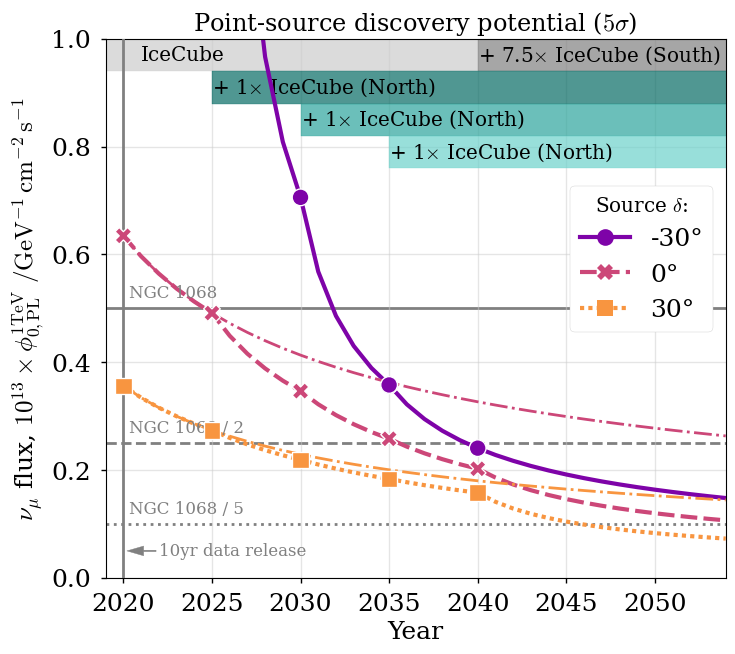

In [5]:
f, ax = plt.subplots(figsize=(8, 7))
# f, ax = plt.subplots(figsize=(6, 5))

edge = 1
ax.set_ylim(0, edge)
width = 0.6e-1
font_color = "0.5"
sigma_ref = 5
ax.axvline(2020, zorder=10, color=font_color)
ax.annotate(
    "10yr data release",
    (2020.2, 0.05),
    (2022, 0.05),
    ha="left",
    va="center",
    zorder=10,
    arrowprops=dict(width=1, headwidth=7, color=font_color),
    color=font_color,
    fontsize="large",
)

for yr_i, series in start_dates.iterrows():
    if not "Gen" in yr_i:
        edge -= width
    length = 50 if not yr_i == "IceCube" else series.end - series.Year
    ax.add_patch(
        Rectangle(
            (series.Year, edge), length, width, color=series.colors, zorder=1, alpha=0.7
        )
    )
    ax.text(
        x=series.Year if yr_i != "IceCube" else 2021,
        y=edge + 0.5 * width,
        s=series.label,
        ha="left",
        va="center",
        fontsize="x-large",
        zorder=2,
    )
# plenum evolution
ax = sns.lineplot(
    data=flux.loc[(flux.sigma == sigma_ref) & (flux.identifier == "PLEnuM")],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style_order=["-30°", "0°", "30°"],
    style="dec_label",
    units="dec",
    lw=3,
    legend=False,
    palette="plasma",
)
# icecube-only extrapolated
ax = sns.lineplot(
    data=flux.loc[
        (flux.sigma == sigma_ref) & (flux.identifier == "IceCube extrapolated")
    ],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    units="dec",
    lw=2, ls="-.",
    legend=False,
    palette="plasma",
)

selection = flux.loc[(flux.sigma == sigma_ref) & (flux.identifier == "PLEnuM")]
selection = selection.loc[(selection.Year < 2041) & (selection.Year % 5 == 0)]
ax = sns.scatterplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style="dec_label",
    markers=["X", "s", "o"],
    s=12**2,
    palette="plasma",
    ax=ax,
    legend=False,
    zorder=11,
)
# extra plotting for legend
selection = flux.loc[(flux.sigma == sigma_ref) & (flux.identifier == "PLEnuM")]
selection = selection.loc[selection.Year == 2035]
ax = sns.lineplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style_order=["-30°", "0°", "30°"],
    style="dec_label",
    units="dec",
    lw=3,
    ms=12,
    palette="plasma",
    markers=["o", "X", "s"],
)

legend = ax.legend(
    bbox_to_anchor=(1.0, 0.75),
    framealpha=1,
    loc=1,
    title="Source $\delta$:",
)
plt.setp(legend.get_title(), fontsize="x-large")
for line in legend.get_lines():
    line.set_linewidth(3)
    line.set_markersize(12)

ax.set_xlim(2019, yr_max - 1)
ax.set_ylabel(
    r"$\nu_\mu$ flux, $10^{13} \times \phi_{0, \rm PL}^{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$",
)

for ii, _ls in zip([1, 2, 5], ["-", "--", ":"]):
    ax.axhline(st.PHI_NGC * 1e13 / ii, ls=_ls, lw=2, color=font_color, zorder=0)
    ax.text(
        x=2020 + 0.3,
        y=0.02 + st.PHI_NGC * 1e13 / ii,
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize="large",
    )

ax.grid(alpha=0.5)

ax.set_title("Point-source discovery potential ($5 \sigma$)", fontsize="xx-large")
# f.savefig("wherever.pdf") #

## same plot, but for energy cutoff identification

In [6]:
flux = pd.read_csv(
    "/home/hpc/capn/capn102h/repos/Plenum/local/source_spectrum_time-evolution.csv"
)

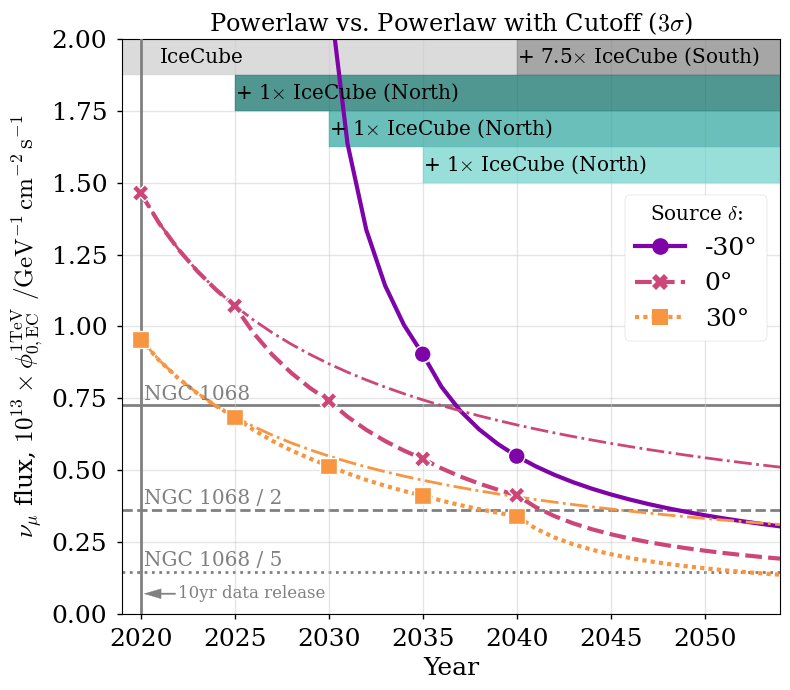

In [7]:
f, ax = plt.subplots(figsize=(8, 7))

edge = 2
ax.set_ylim(0, edge)

width = 1.25e-1
font_color = "0.5"

ax.axvline(2020, zorder=10, color=font_color)
ax.annotate(
    "10yr data release",
    (2020.2, 0.07),
    (2022, 0.07),
    ha="left",
    va="center",
    zorder=10,
    arrowprops=dict(width=1, headwidth=7, color=font_color),
    color=font_color,
    fontsize="large",
)

for yr_i, series in start_dates.iterrows():
    if not "Gen" in yr_i:
        edge -= width
    length = 50 if not yr_i == "IceCube" else series.end - series.Year
    ax.add_patch(
        Rectangle(
            (series.Year, edge), length, width, color=series.colors, zorder=1, alpha=0.7
        )
    )
    ax.text(
        x=series.Year if yr_i != "IceCube" else 2021,
        y=edge + 0.5 * width,
        s=series.label,
        ha="left",
        va="center",
        fontsize="x-large",
        zorder=20,
    )

ax = sns.lineplot(
    data=flux.loc[(flux.sigma == 3) & (flux.identifier == "PLEnuM")],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style_order=["-30°", "0°", "30°"],
    #dashes=[(1, 1), (1, 0), (2, 2)],
    style="dec_label",
    units="dec",
    lw=3,
    legend=False,
    palette="plasma",
)


selection = flux.loc[flux.sigma == 3]
selection = selection.loc[flux.identifier == "PLEnuM"]
selection = selection.loc[(selection.Year < 2041) & (selection.Year % 5 == 0)]
ax = sns.scatterplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style="dec_label",
    markers=["X", "s", "o"],
    s=12**2,
    palette="plasma",
    ax=ax,
    legend=False,
    zorder=11,
)

selection = flux.loc[flux.sigma == 3]
selection = selection.loc[flux.identifier == "PLEnuM"]
selection = selection.loc[selection.Year == 2035]
ax = sns.lineplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style_order=["-30°", "0°", "30°"],
    #dashes=[(1, 1), (1, 0), (2, 2)],
    style="dec_label",
    units="dec",
    lw=3,
    ms=12,
    palette="plasma",
    markers=["o", "X", "s"],
)
# icecube extrapolated
ax = sns.lineplot(
    data=flux.loc[(flux.sigma == 3) & (flux.identifier == "IceCube extrapolated")],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    units="dec",
    lw=2, ls="-.",
    legend=False,
    palette="plasma",
)

legend = ax.legend(
    bbox_to_anchor=(1.0, 0.75),
    framealpha=1,
    loc=1,
    title="Source $\delta$:",
)
plt.setp(legend.get_title(), fontsize="x-large")
for line in legend.get_lines():
    line.set_linewidth(3)
    line.set_markersize(12)

ax.set_xlim(2019, yr_max - 1)
ax.set_ylabel(
    r"$\nu_\mu$ flux, $10^{13} \times \phi_{0, \rm EC}^{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$",
)

for ii, _ls in zip([1, 2, 5], ["-", "--", ":"]):
    ax.axhline(ngc_cut_flux.norm * 1e13 / ii, ls=_ls, lw=2, color=font_color, zorder=0)
    ax.text(
        x=2020 + 0.2,
        y=0.02 + ngc_cut_flux.norm * 1e13 / ii,
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize="x-large",
    )

ax.grid(alpha=0.5)

ax.set_title("Powerlaw vs. Powerlaw with Cutoff ($3 \sigma$)", fontsize="xx-large")
f.tight_layout()
#f.savefig("../wherever/ecut.pdf")

# 2D ngc contour
## Asimov data

In [8]:
contour_formats = {
    "IceCube": {"colors": [st.poles["IceCube"]["color"]], "linestyles": "--"},
    "P-ONE": {"colors": [st.poles["P-ONE"]["color"]], "linestyles": ":"},
    "Plenum-1": {
        "colors": [st.poles["Plenum-1"]["color"]],
        "linestyles": st.poles["Plenum-1"]["ls"],
    },
    "Plenum-2": {
        "colors": [st.poles["Plenum-2"]["color"]],
        "linestyles": st.poles["Plenum-2"]["ls"],
    },
}
detector_keys = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
energy_reso = ["baseline", "improved"]

In [9]:
SPL_df = pd.read_csv(join(st.LOCALPATH, "ngc_contour_spl.csv"))
SPL_df


,Unnamed: 0,LLH,energy_res,ident,ts,conv,phi_astro,gamma,delta_ts
0,0,global,baseline,IceCube,-3.070738e+05,1.000000,1.0,3.20,NaN
1,1,local,baseline,IceCube,-3.070695e+05,1.027756,0.4,2.70,4.270468
2,2,local,baseline,IceCube,-3.070700e+05,1.029370,0.4,2.75,3.768071
3,3,local,baseline,IceCube,-3.070702e+05,1.030796,0.4,2.80,3.590354
4,4,local,baseline,IceCube,-3.070701e+05,1.032049,0.4,2.85,3.641292
...,...,...,...,...,...,...,...,...,...
5203,5203,local,improved,Plenum-2,-1.228628e+06,0.953257,1.6,3.75,199.960977
5204,5204,local,improved,Plenum-2,-1.228591e+06,0.950995,1.6,3.80,237.284002
5205,5205,local,improved,Plenum-2,-1.228548e+06,0.948555,1.6,3.85,280.005242
5206,5206,local,improved,Plenum-2,-1.228499e+06,0.945943,1.6,3.90,328.749404


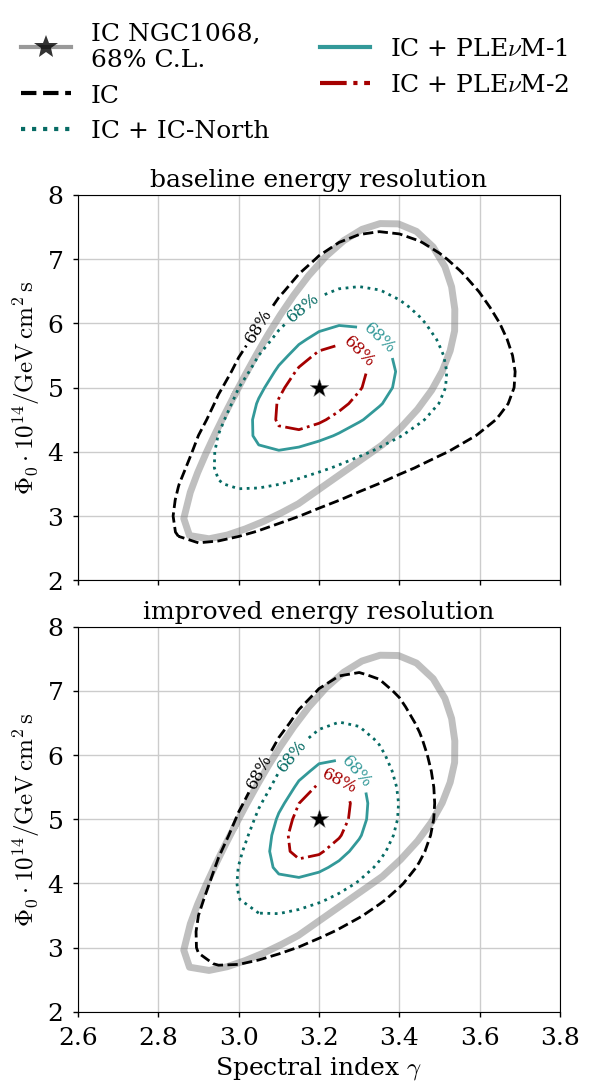

In [10]:
ref_color = "gray"

f, axes = plt.subplots(nrows=2, figsize=(6, 11), sharex=True)

for ii, eres_key in enumerate(energy_reso):
    ax = axes[ii]
    ax.plot(
        gamma_c_68,
        phi_c_68 * 1e11,
        color=ref_color,
        ls="-",
        lw=5,
        alpha=0.5,
    )

    # draw contour levels
    cvals = [0.32]
    lbs = ["68%"]
    levels = chi2.isf(cvals, 2)

    res_local = SPL_df.loc[(SPL_df.LLH == "local") & (SPL_df.energy_res == eres_key)]
    res_global = SPL_df.loc[(SPL_df.LLH == "global") & (SPL_df.energy_res == eres_key)]

    for ident, series in res_local.groupby("ident"):
        local_pivot = series.pivot(
            index="gamma", columns="phi_astro", values="delta_ts"
        )
        sc = ax.contour(
            local_pivot.index,
            local_pivot.columns * ngc_flux.norm * 1e14,
            local_pivot.T,
            levels=levels,
            lw=3,
            **contour_formats[ident],
        )
        fmt = {l: s for l, s in zip(sc.levels, lbs)}
        ax.clabel(sc, levels, fmt=fmt, fontsize=12)
    # best fit
    ax.scatter(
        res_global.gamma.unique(),
        res_global.phi_astro.unique() * ngc_flux.norm * 1e14,
        marker="*",
        s=200,
        color="k",
        edgecolor=ref_color,
    )

    ax.set_ylim(2, 8)
    ax.set_xlim(2.6, 3.8)
    ax.set_ylabel(r"$\Phi_0 \cdot 10^{14} / {\rm GeV\, cm^2\, s}$")
    ax.set_title(f"{eres_key} energy resolution")

ax.set_xlabel(r"Spectral index $\gamma$")

lines = [
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=ref_color,
        ls="-",
        lw=3,
        markersize=18,
        alpha=0.8,
        marker="*",
        mfc="k",
        mec=ref_color,
        label="IC NGC1068,\n68% C.L.",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["IceCube"]["colors"][0],
        ls=contour_formats["IceCube"]["linestyles"],
        lw=3,
        label="IC",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["P-ONE"]["colors"][0],
        ls=contour_formats["P-ONE"]["linestyles"],
        lw=3,
        label="IC + IC-North",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-1"]["colors"][0],
        ls=contour_formats["Plenum-1"]["linestyles"],
        lw=3,
        label=r"IC + PLE$\nu$M-1",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-2"]["colors"][0],
        ls=contour_formats["Plenum-2"]["linestyles"],
        lw=3,
        label=r"IC + PLE$\nu$M-2",
    ),
]
f.legend(
    handles=lines,
    loc="upper center",
    ncol=2,
    # fontsize="large",
    frameon=False,
)
# flux_str = r"$\frac{{\rm d}\Phi_{\rm astro}^{\nu_\mu + \bar{\nu}_\mu}}{{\rm d}E}"
# flux_str += r"= \Phi_0 \left( \frac{E}{\rm 1\,TeV} \right)^{-\gamma}$"
# ax.text(
#     2.65,
#     7.0,
#     flux_str,
#     fontsize=20,
#     bbox=dict(boxstyle="round", facecolor="w", edgecolor="gray", alpha=0.8),
# )
# f.suptitle(f"NGC1068 contour", fontsize="xx-large")
f.tight_layout()
f.subplots_adjust(top=0.82)

#f.savefig(join(st.BASEPATH, "plots/ngc_paper/2D_scan_ngc1068.pdf"))

## Experimental data & comparison

In [11]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(
    join(st.BASEPATH, "resources/ngc_paper_68_contour.txt")
)
phi_c_68 /= 1e11

# 10yr PS paper (data release)
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(
    join(st.BASEPATH, "resources/tenyr_paper_68_contour.txt")
)
phi_c_68_prev *= 1e-3

In [12]:
out_global = [
    np.array([0.93204454, 0.7401632, 3.26188143]),
    4836.354277717709,
]  # best-fit on exp data

In [13]:
collect_times = {
    "IceCube NGC 1068 (2020)": {
        "data": [2008.2633309090984, 2018.517733159589],
        "plotting_kw": {"marker": "o", "ls": ":", "color": "k", "ms": 10},
    },
    "PLEnuM data": {
        "data": [2012.318105689836, 2018.517733159589],
        "plotting_kw": {"marker": "*", "ls": "-", "color": "tomato", "ms": 15},
    },
    "IceCube NGC 1068 (2022)": {
        "data": [2011.3616438356164, 2020.4071038251366],
        "plotting_kw": {"marker": "s", "ls": "--", "color": "k", "ms": 10},
    },
}

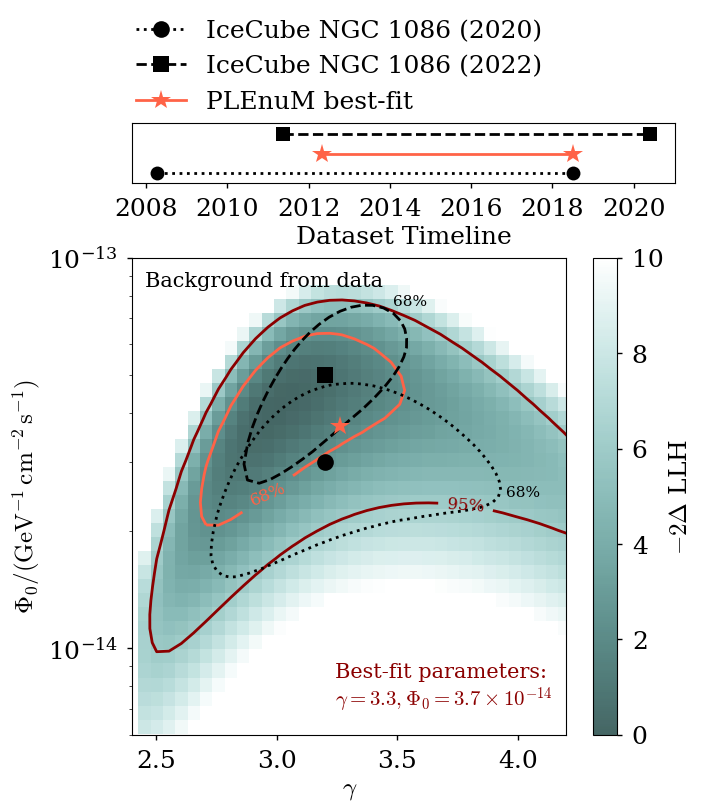

In [14]:
sig_ts = pd.read_csv(join(st.BASEPATH, "resources/ngc_2D_LLH_scan_exp.csv"))
sig_ts["norm"] = sig_ts["ns"] * ngc_flux.norm
sig_ts_piv = sig_ts.pivot(index="norm", columns="gamma", values="delta_ts")
cvals = [0.32, 0.05]
lbs = ["68%", "95%"]
levels = chi2.isf(cvals, 2)
cur_cmap = sns.cubehelix_palette(
    start=-0.6, rot=0, light=1, dark=0.2, as_cmap=True, reverse=True
)  # start=0.75, rot=-0.5


f, axes = plt.subplots(
    figsize=(7, 9), nrows=2, gridspec_kw={"height_ratios": [1, 8], "hspace": 0.28}
)

ax = axes[0]
# timeline
for ii, key in enumerate(collect_times):
    if key == "all":
        continue
    ax.plot(
        collect_times[key]["data"],
        np.repeat(ii, len(collect_times[key]["data"])),
        **collect_times[key]["plotting_kw"],
    )

ax.set_yticks([])
ax.grid(False)
ax.set_ylim(-0.5, 2.6)
ax.set_xlabel("Dataset Timeline")

ax = axes[1]

im = ax.pcolormesh(
    sig_ts_piv.columns,
    sig_ts_piv.index,
    sig_ts_piv,
    vmin=0,
    vmax=10,
    cmap=cur_cmap,
    alpha=0.8,
    linewidth=0,
    rasterized=True,
)
cb = plt.colorbar(im)
cb.set_label(r"$-2 \Delta$ LLH")

ax.plot(gamma_c_68_prev, phi_c_68_prev, color="k", ls=":")
ax.plot(
    3.2,
    3e-14,
    color="k",
    marker="o",
    label="IceCube NGC 1086 (2020)",
    ms=12,
    ls=":",
)

ax.plot(gamma_c_68, phi_c_68 * 1e-3, color="k", ls="--")
ax.plot(
    3.2,
    5e-14,
    color="k",
    marker="s",
    label="IceCube NGC 1086 (2022)",
    ms=12,
    ls="--",
)


ax.plot(
    out_global[0][2],
    out_global[0][1] * ngc_flux.norm,
    color="tomato",
    marker="*",
    ms=15,
    label="PLEnuM best-fit",
)
sc = ax.contour(
    sig_ts_piv.columns,
    sig_ts_piv.index,
    sig_ts_piv,
    levels=levels,
    lw=3,
    colors=["tomato", "darkred"],
    zorder=1,
)

fmt = {l: s for l, s in zip(sc.levels, lbs)}
plt.clabel(sc, levels, fmt=fmt, fontsize=12)


ax.set_xlabel(r"$\gamma$")
ax.set_ylabel(r"$\Phi_0 / ({\rm GeV^{-1}\, cm^{-2}\, s^{-1}})$")
f.legend(
    loc="upper center",
    frameon=False,
    bbox_to_anchor=(0.42, 0.93),
)

ax.text(
    0.97,
    0.06,
    "Best-fit parameters: \n"
    + rf"$\gamma={out_global[0][2]:1.1f}, \Phi_0={out_global[0][1] * ngc_flux.norm * 1E14:1.1f}\times 10^{{-14}}$",
    fontsize=15,
    transform=ax.transAxes,
    ha="right",
    color="darkred",
)

ax.text(
    0.6,
    0.9,
    "68%",
    fontsize=11,
    transform=ax.transAxes,
)

ax.text(
    0.86,
    0.5,
    "68%",
    fontsize=11,
    transform=ax.transAxes,
)


ax.set_yscale("log")
ax.set_ylim(6e-15, 1e-13)
ax.set_xlim(2.4, 4.2)
plt.grid(False)
title_str = "Background from data"
save_str = "../../plots/ngc_paper/experimental_data_2Dscan.pdf"
ax.text(0.03, 0.94, title_str, fontsize=15, transform=ax.transAxes)

f.subplots_adjust(top=0.79)
f.savefig(save_str, bbox_inches="tight")

# Flux models and analysis histogram slices

In [15]:
local_background_flux = np.genfromtxt(join(st.BASEPATH, "resources/local_background_ngc.txt"))


# source $\nu_\mu$ : 88.1
# atmo. $\nu_\mu$ : 1311.2 (within 28 deg²)
# source $\nu_\mu$ : 88.1
# atmo. $\nu_\mu$ : 1311.2 (within 28 deg²)


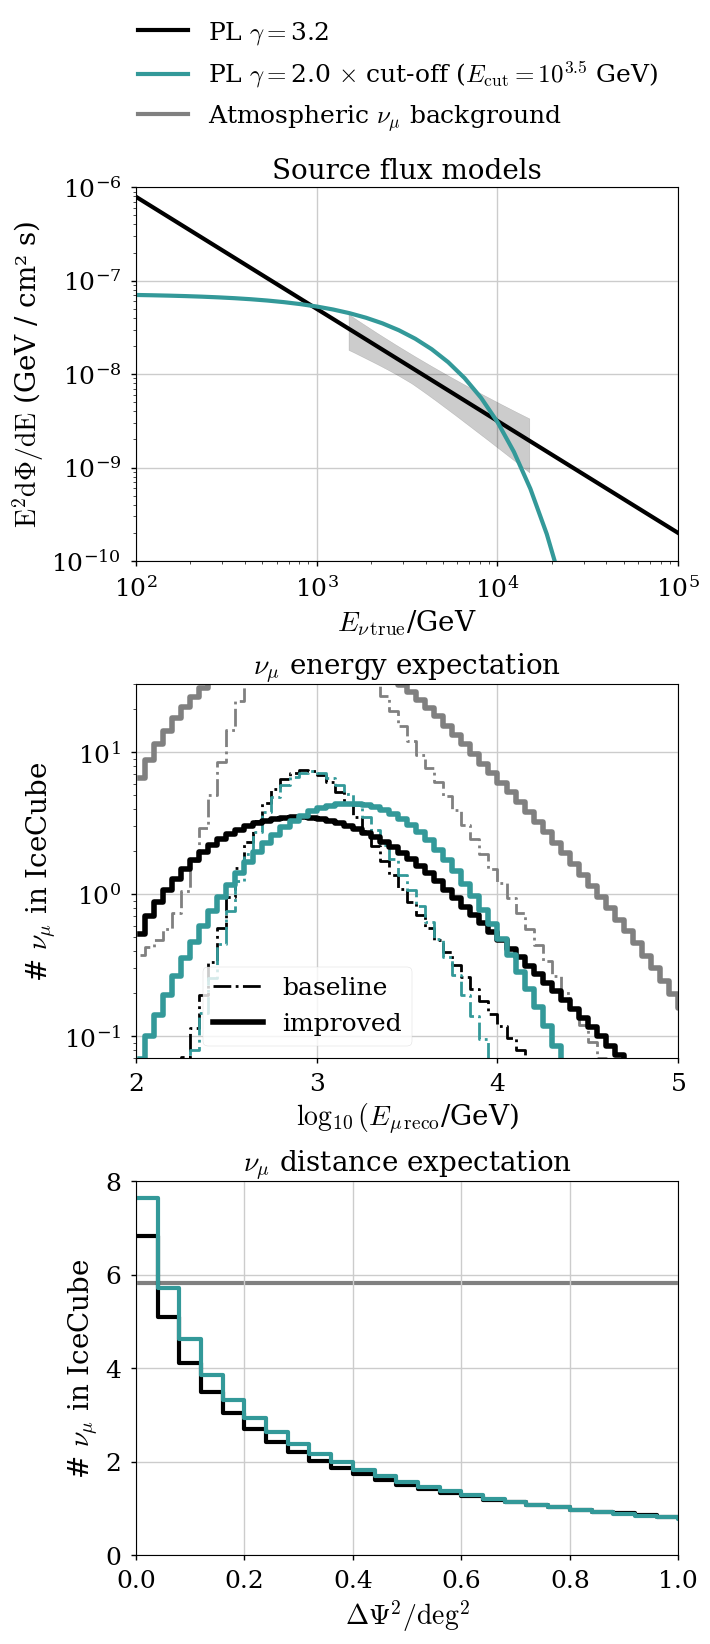

In [16]:
sq_deg = np.pi * st.delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2 # E**y_scaling on y axis

pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

f, axes = plt.subplots(nrows=3, figsize=(7, 19))
ax = axes[0]
fontsize = 20
ax.set_title("Source flux models", fontsize=fontsize)

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# without energy range interval
# x_cont = np.logspace(1.9, 5.1, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, st.E0_NGC, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)

ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"PL $\gamma=${st.GAMMA_NGC}",
    color="k",
    alpha=1,
    lw=3,
)

ax.plot(
    x_evals,
    cut * (x_evals**y_scaling),
    label=rf"PL $\gamma=${st.Gamma_cut} $\times$ "
    + rf"cut-off ($E_{{\rm cut}}=10^{{{st.logE_cut:1.1f}}}$ GeV)",
    color="#339999",
    lw=3,
)
ax.plot(
    10 ** st.logE_mids,
    local_background_flux * sq_deg * (10 ** st.logE_mids ** y_scaling),
    label=r"Atmospheric $\nu_\mu$ background",
    color="gray",
    lw=3,
)

ax.set_yscale("log")
ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)", fontsize=fontsize)
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV", fontsize=fontsize)
ax.set_ylim(1e-10, 1e-6)
ax.set_xlim(1e2, 1e5)
f.legend(
    loc="upper center",
    frameon=False,
    bbox_to_anchor=(0.5, 0.93),
)


### plot Event numbers in E_reco
ii = 0
ax = axes[1]
ident = "IceCube"

for e_name in ["baseline", "improved"]:
    k_b = np.genfromtxt(join(st.BASEPATH, f"resources/background_events_{e_name}.txt"))
    k_s_pl = np.genfromtxt(join(st.BASEPATH, f"resources/PL_events_{e_name}.txt"))
    k_s_cut = np.genfromtxt(join(st.BASEPATH, f"resources/PLC_events_{e_name}.txt"))

    ax = axes[1]
    ax.plot(
        st.logE_reco_mids,
        k_s_pl.sum(axis=0),
        drawstyle="steps-mid",
        label=e_name,
        color="k",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-.",
    )

    ax.plot(
        st.logE_reco_mids,
        k_s_cut.sum(axis=0),
        drawstyle="steps-mid",
        color="#339999",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-.",
    )

    ax.plot(
        st.logE_reco_mids,
        k_b.sum(axis=0),
        drawstyle="steps-mid",
        color="gray",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-.",
    )
    print(rf"# source $\nu_\mu$ : {np.sum(k_s_pl):1.1f}")
    print(rf"# atmo. $\nu_\mu$ : {np.sum(k_b):1.1f} (within {sq_deg:1.0f} deg²)")
ax.set_title(r"$\nu_\mu$ energy expectation", fontsize=fontsize)
ax.set_yscale("log")
ax.set_xlim(2, 5)
ax.set_ylim(7e-2, 3e1)
ax.set_xlabel(r"$\log_{10}(E_{\mu \, \rm reco}$/GeV)", fontsize=fontsize)
ax.set_ylabel(r"# $\nu_\mu$ in IceCube", fontsize=fontsize)
ax.legend(loc=3, bbox_to_anchor=(0.1, 0.0))
ax.set_xticks([2, 3, 4, 5])

ax = axes[2]
ax.plot(
    np.concatenate([[-0.1], st.psi2_mids]),
    np.concatenate([[0], k_s_pl.sum(axis=1)]),
    drawstyle="steps-mid",
    color="k",
    lw=3,
)

ax.plot(
    np.concatenate([[-0.1], st.psi2_mids]),
    np.concatenate([[0], k_s_cut.sum(axis=1)]),
    drawstyle="steps-mid",
    color="#339999",
    lw=3,
)

ax.plot(
    np.concatenate([[-0.1], st.psi2_mids]),
    np.concatenate([[0], k_b.sum(axis=1)]),
    drawstyle="steps-mid",
    color="gray",
    lw=3,
    zorder=0,
)

ax.set_ylabel(r"# $\nu_\mu$ in IceCube", fontsize=fontsize)
ax.set_xlim(0, 1)
ax.set_ylim(0, 8)
ax.set_xlabel(r"$\Delta \Psi ^2 / {\rm deg}^2$", fontsize=fontsize)
ax.set_title(r"$\nu_\mu$ distance expectation", fontsize=fontsize)
f.subplots_adjust(hspace=0.33, top=0.83)

# f.savefig(
#     join(BASEPATH, f"plots/ngc_paper/ngc_spectral_improved_dpsi.pdf"),
#     bbox_inches="tight",
# )